In [24]:
import nengo
import nengo.spa as spa

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from utils import gen_feed_func, gen_vecs_jan

In [42]:
n_items = 256
t_present = 0.04
D = 16
dt = 0.001
similarity = 0.9
n_neurons = 250
assoc_neurons = 25

In [43]:
import warnings; warnings.simplefilter('ignore')

vocab = spa.Vocabulary(D)
stim_lbl = ['S1']
targ = np.zeros(n_items)
targ[0] = 1
targ_class = []
targ_class.append(targ)

S1 = vocab.parse('S1')

for i in range(2, n_items+1):
    v = vocab.parse('S1+0.4*R%d' % (i-1))
    v.normalize()
    vocab.add('S%d' % i, v)
    stim_lbl.append('S%d' % i)
    targ = np.zeros(n_items)
    targ[i-1] = 1
    targ_class.append(targ)

stim_vecs = [vocab.parse(ss).v for ss in stim_lbl]

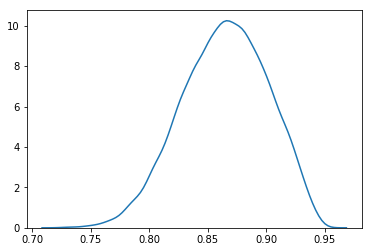

In [44]:
import itertools

simi = []
for vec in itertools.combinations(stim_vecs, 2):
    simi.append(np.dot(vec[0], vec[1]))

sns.kdeplot(simi)

# Decoding directly from oscillator

In [45]:
with nengo.Network() as model:
    in_nd = nengo.Node(gen_feed_func(vocab, stim_lbl, t_present))

    recog = nengo.Ensemble(n_neurons, D)

    cleanup = nengo.networks.AssociativeMemory(input_vectors=stim_vecs, n_neurons=assoc_neurons)
    
    nengo.Connection(in_nd, recog)
    nengo.Connection(recog, cleanup.input)
    nengo.Connection(cleanup.output, recog, transform=-10)
    
    p_in = nengo.Probe(in_nd)
    p_osc = nengo.Probe(recog, synapse=0.01)
    p_filt_spikes = nengo.Probe(recog.neurons, synapse=0.01)

In [46]:
with nengo.Simulator(model) as sim:
    sim.run(t_present*n_items)

Building finished in 0:00:24.                                                   
Simulating finished in 0:00:15.                                                 


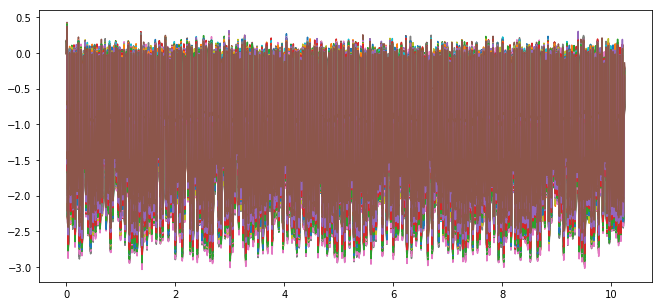

In [47]:
plt.figure(figsize=(11, 5))
plt.plot(sim.trange(), spa.similarity(sim.data[p_osc], stim_vecs));

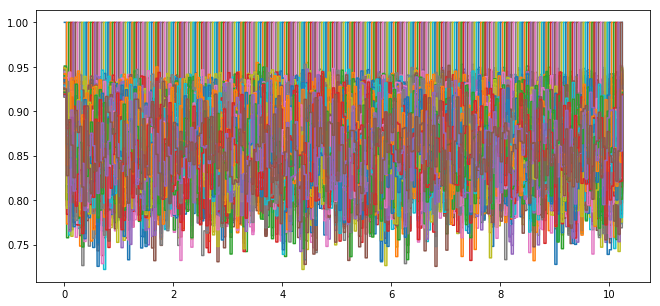

In [48]:
plt.figure(figsize=(11, 5))
plt.plot(sim.trange(), spa.similarity(sim.data[p_in], stim_vecs));

In [49]:
series_len = t_present / dt

repped = []
for targ in targ_class:
    repped.append(np.repeat(targ[None, :], series_len, axis=0))

targ_dat = np.concatenate(repped, axis=0)

In [50]:
solver = nengo.solvers.LstsqL2(reg=0.02)
decoders, stats = solver(sim.data[p_filt_spikes], targ_dat)
decoded = np.dot(sim.data[p_filt_spikes], decoders)

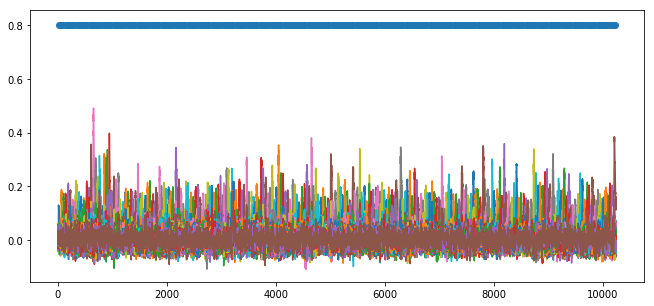

In [51]:
plt.figure(figsize=(11, 5))
samples = np.arange(0, int(t_present*n_items/dt), int(t_present/dt)) + int(t_present/dt/2)
plt.scatter(samples, np.ones(n_items)*0.8)
plt.plot(decoded);

In [52]:
np.argmax(decoded[samples], axis=1) == np.arange(n_items)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

# Decoding from temporal network

Not required due to how effective just decoding from the oscillator is